## ノイズフィルター

### この節について

この節では、ノイズフィルターについて解説します。

このページ内の解説は簡略版です。 詳しい解説については技術書典6で配布した書籍「ゼロから作るRAW現像」を参照下さい。

[目次ページに戻る](http://bit.ly/raw_toc)

__今回の処理はメモリーを大量に使用します。もし実行中エラーが発生した場合は、メニューのRuntimeからReset All Runtimesを選択した後ノートのはじめから再実行してください。__

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [0]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then \
    wget http://bit.ly/raw_process -O raw_process.py; fi

from raw_process import simple_demosaic, white_balance, \
    black_level_correction, gamma_correction, demosaic, \
    defect_correction, color_correction_matrix, \
    lens_shading_correction

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then \
    wget http://bit.ly/raw_chart_jpg -O chart.jpg; fi
 
# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロード。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
# もし日本語が文字化けしている場合以下の３行の行頭の#を削除して実行後、
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json
# その後Runtime->Restart Runtime選択してページ全体を再実行

### 実際の画像のノイズ

それでは前章で処理した画像のノイズを観察してみましょう。

まずはRAW現像します。

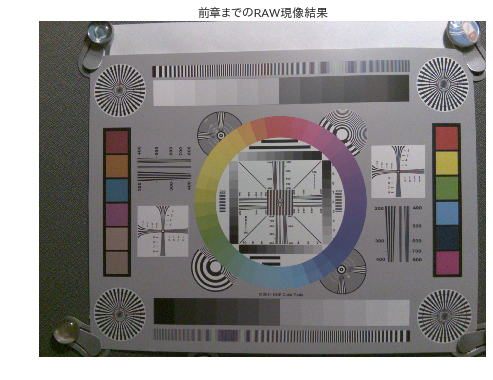

In [0]:
blc, pattern = raw.black_level_per_channel, raw.raw_pattern
blc_raw = black_level_correction(raw_array, blc, pattern)
threshold = 16
dpc_raw = defect_correction(blc_raw, threshold)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(dpc_raw, lsc)
gains, colors = raw.camera_whitebalance, raw.raw_colors
wb_raw = white_balance(lsc_raw, gains, colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array(
    [6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)

# 画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"前章までのRAW現像結果")
plt.show()

この画像を拡大すると、このようになっています。

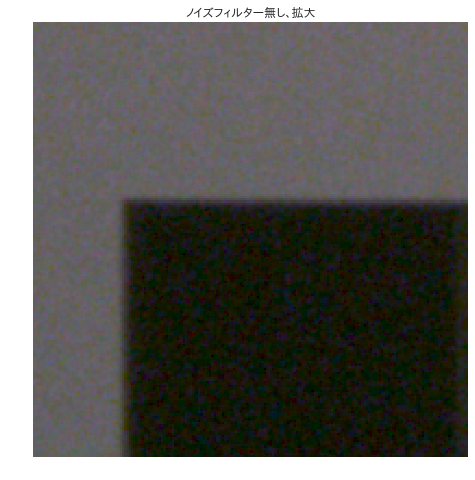

In [0]:
# 画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.show()

なんだかざらざらしていますし、本来グレーや黒の部分に色が浮かんでいます。なるべく明るくして撮影したのですが、まだだいぶノイズがのっているようです。

では実際どの程度の量のノイズがあるのか測定してみましょう。

![ノイズ測定領域](https://github.com/moizumi99/camera_raw_processing/raw/master/Figures/fig_5_2_1.png)

図のグレイパッチ部分（赤い長方形で囲った部分）のノイズ量を実際に測定してみます。

各グレイパッチの座標を画像ビューワーなどで調べ、測定領域を決めておきます。

今回は次のような座標をとり、その点から右下の100x100画素の正方形の領域を測定します。

In [0]:
patches = [(2586, 2086), (2430, 2092), (2272, 2090), (2112, 2090), 
           (1958, 2086), (1792, 2094), (1642, 2096), (1486, 2090), 
           (1328, 2090), (1172, 2086), (1016,2084), (860, 2084),
           (866, 482), (1022, 480), (1172, 476), (1328, 474), 
           (1480, 470), (1634, 466),(1788, 462), (1944, 460), 
           (2110, 452), (2266, 452), (2424, 448), (2586, 442)]

各パッチ内の画素の分散と平均値を測定してみます。
画像のフォーマットがBayerなので、各色チャンネル毎に統計をとります。

In [0]:
variances = []
averages = []
for index, (dx, dy) in enumerate(((0, 0), (1, 0), (0, 1), (1, 1))):
    for patch in patches:
        x, y = patch
        p = blc_raw[y+dy:y+100:2, x+dx:x+100:2]
        s2 = (p * p).mean()
        av = p.mean()
        v = s2 - av * av
        variances.append(v)
        averages.append(av)

測定結果を見てみましょう。

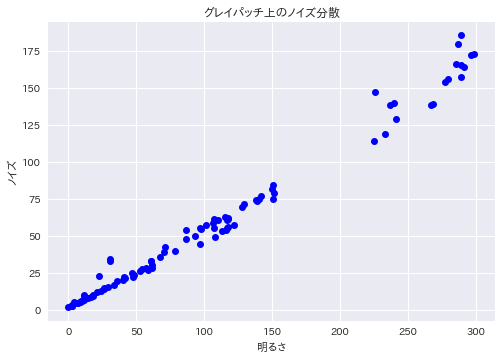

In [0]:
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.title(u"グレイパッチ上のノイズ分散")
plt.xlabel(u"明るさ")
plt.ylabel(u"ノイズ")
plt.show()

どうやら、分散は画素の値に対してほぼ線形になっているようです。光ポワッソンノイズが支配的だと予想されます。

一次式で近似してみましょう。

In [0]:
par = np.polyfit(averages, variances, 1)
print(par)

[ 0.56326801 -1.1732412 ]


では、近似した１次式ともとのグラフを並べてみましょう。

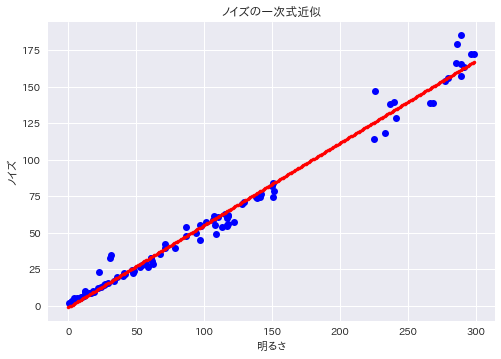

In [0]:
xs = np.arange(0, 300, 1)
ys = par[1] + par[0] * xs
plt.plot(averages, variances, linestyle='None', 
         marker='o', color='blue')
plt.plot(xs, ys, linestyle='None', marker='.', color='red')
plt.title(u"ノイズの一次式近似")
plt.xlabel(u"明るさ")
plt.ylabel(u"ノイズ")
plt.show()

ほぼ近似できているようです。

### ノイズフィルターの定番バイラテラルフィルター

ノイズフィルターに求められる特性として、ノイズは取り除いてほしいが、元の画像に含まれる情報は残しておきたい、というものがあります。

このような矛盾する要求に答えるものとしてバイラテラルフィルター[^1]があります。

[^1]: Bilateral Filtering for Gray and Color Images, C. Tomasi and R. Manduchi, Proceedings of the 1998 IEEE International Conference on Computer Vision,  pp. 839–846, 1998

### バイラテラルノイズフィルターの適用

ではこのノイズフィルターを実際の画像に適用してみましょう。

Bayerフォーマットのままではフィルターがかけにくいので、デモザイク後の値を使用します。一応この段階の画像を確認しておきましょう。

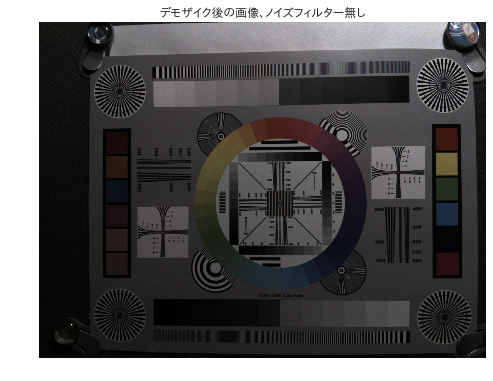

In [0]:
outimg = dms_img / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"デモザイク後の画像、ノイズフィルター無し")
plt.show()

さて、ホワイトバランスやデモザイク処理を行った後でも、ノイズの分散は画素の値に比例するのでしょうか？
RGBの平均に対して確かめてみましょう。

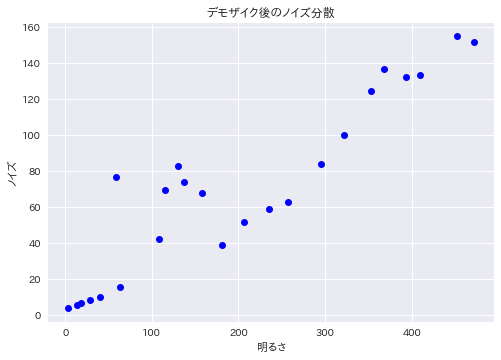

In [0]:
luma_img = dms_img.mean(2)
variances = []
averages = []
for patch in patches:
    x, y = patch
    p = luma_img[y:y+100, x:x+100]
    s2 = (p * p).mean()
    av = p.mean()
    v = s2 - av * av
    variances.append(v)
    averages.append(av)

plt.plot(averages, variances, linestyle='None', 
         marker='o', color='blue')
plt.title(u"デモザイク後のノイズ分散")
plt.xlabel(u"明るさ")
plt.ylabel(u"ノイズ")
plt.show()

先ほどとは多少様子が違いますが、線形近似で大丈夫そうです。

傾きを求めて確かめてみましょう。

傾き 0.29998133477267147 切片 10.29069500247214


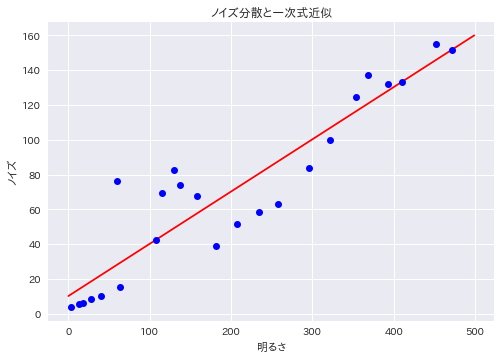

In [0]:
par = np.polyfit(averages, variances, 1)
print(u'傾き', par[0], '切片', par[1])

xs = np.arange(0, 500)
ys = par[0] * xs + par[1]
plt.plot(xs, ys, color='red')
plt.plot(averages, variances, linestyle='None', 
         marker='o', color='blue')
plt.title('ノイズ分散と一次式近似')
plt.xlabel(u"明るさ")
plt.ylabel(u"ノイズ")
plt.show()

Bayerでの測定に比べると誤差が大きいようですが、この程度のずれなら使えそうです。

さあ、これでノイズフィルターを適用する準備ができました。実際にかけてみましょう。
今回はフルカラーなので、ウェイトの計算はRGBの平均に対して行い、フィルターの適用は各カラーごとに行うという方法を使っています。
コード中、coefがバイラテラルフィルターの式の$a$に相当します。なお今回は$b = 0$としました。

In [0]:
# 注：これは処理をわかりやすく書いたもので非常に実行速度が遅い。
# 実際にはこの後の高速版を使用することをおすすめする
import math

coef = 0.1
img_flt = dms_img.copy()
for y in range(2, h-2):
    for x in range (2, w - 2):
        # 5x5の平均値からノイズの分散(sigma) を推定する
        average = luma_img[y-2:y+3, x-2:x+3].mean()
        sigma = par[0] * average
        sigma = sigma if sigma > 0 else 1

        weight = np.zeros((5, 5))
        out_pixel = np.zeros(3)
        norm = 0
        # 5x5内の各画素毎に重みを計算する
        for dy in range(-2, 3):
            for dx in range(-2, 3):
                # 中心画素との差
                diff = luma_img[y + dy, x + dx] - luma_img[y, x]
                diff_norm = diff * diff / sigma
                # 差と分散からウェイトを計算し、加重平均値を求める
                weight = math.exp(-coef * diff_norm)
                out_pixel += weight * dms_img[y + dy, x + dx, :]
                norm += weight
        # 各色毎にウェイトの和で正規化する
        img_flt[y, x, 0] = out_pixel[0] / norm
        img_flt[y, x, 1] = out_pixel[1] / norm
        img_flt[y, x, 2] = out_pixel[2] / norm

表示します。

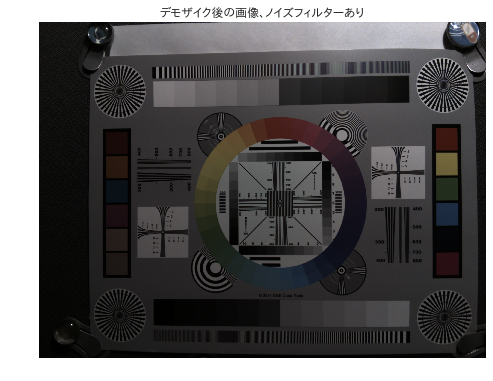

In [0]:
outimg = img_flt.copy()
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"デモザイク後の画像、ノイズフィルターあり")
plt.show()

このままではわかりにくいので、残りの処理（カラーマトリクスとガンマ補正）を行います。

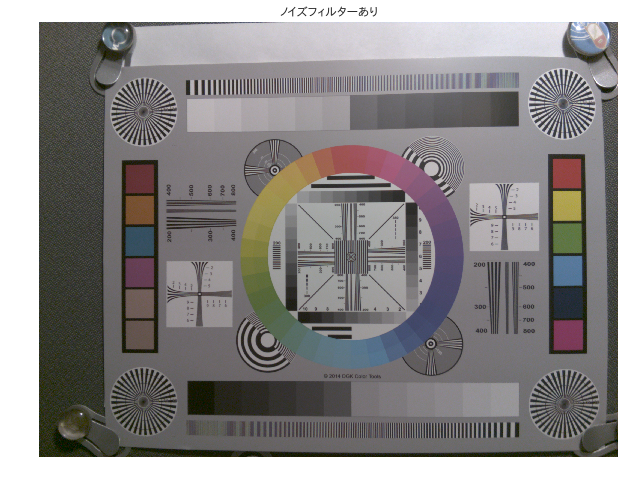

In [0]:
ccm_flt_img = color_correction_matrix(img_flt, color_matrix)
gmm_flt_img = gamma_correction(ccm_flt_img / white_level, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(gmm_flt_img)
plt.axis('off')
plt.title(u"ノイズフィルターあり")
plt.show()

拡大してノイズフィルターなしの画像と比較してみましょう。

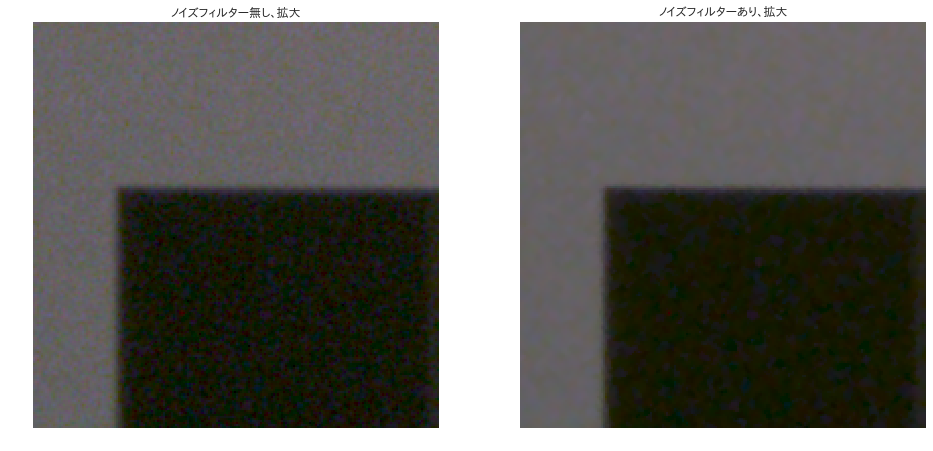

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gmm_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.subplot(1, 2, 2)
plt.imshow(gmm_flt_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルターあり、拡大")
plt.show()

正常に処理できているようです。他の部分も見てみましょう。

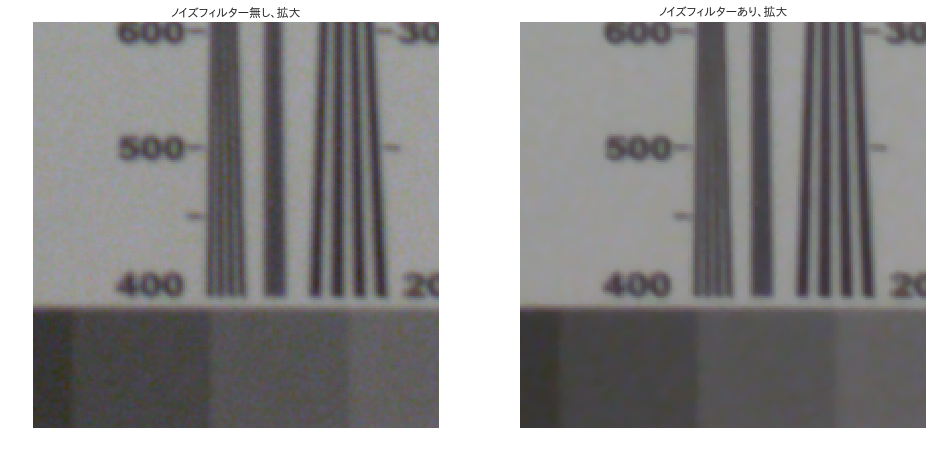

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gmm_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.subplot(1, 2, 2)
plt.imshow(gmm_flt_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"ノイズフィルターあり、拡大")
plt.show()

平坦部のノイズは減っていますが、ディテールの大部分は残っていることがわかります。

### ノイズフィルター処理の高速化

最後にもう一点だけ、処理の高速化について触れます。この項はPythonでの最適化に興味のない方は読み飛ばしてかまいません。

上記のノイズフィルターのコードはプログラムとしては動作しますが、非常に遅いコードです。

これはPythonの性能上しかたのない部分もあるのですが、numpyなどの機能を利用することでかなり改善できます。[^2]

[^2]: ただし、処理の内容が一見わかりにくくなるというトレードオフがあります。これが理由で先程はベタ書きの処理を紹介しました。

まず、一般的な傾向としてnumpyではループの処理は遅いので、なるべくforループを減らしたほうが高速になる場合が多いです。
numpyにはこのような用途のためにstride_tricksというライブラリがあります。今回はこのライブラリの[as_strided](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.lib.stride_tricks.as_strided.html)という機能を利用してループを減らしていきましょう。

まずは、RGBの平均画像(luma_img)から分散を計算します。

In [0]:
# as_stridedのインポート
from numpy.lib.stride_tricks import as_strided
import scipy

# scipyの機能を使って、5x5の平均値フィルター（uniform_filter)をかける。
# mode='mirror'は縁の部分で折り返し処理をする事をしめす。
average = scipy.ndimage.filters.uniform_filter(luma_img, 5, 
                                               mode='mirror')
# ノイズモデルの切片(par[0])と傾き(par[1])からノイズ量を求める。
sigma_map = average * par[1] + par[0]
sigma_map[sigma_map < 1] = 1
# stridesはnumpyの配列で引数が1変わった時のオフセットの差（ストライド）。
# この場合simga_map[0, 0]とsigma_map[1, 0]との間のストライドはsy。
# sigma_map[0, 0]とsigma_map[0, 1]との間のストライドはsx。
sy, sx = sigma_map.strides
# as_stridedを使って5x5の各画素のコピーを作り出す。
# 結果はh x w x 5 x 5の4次元配列。
# 例えばsigma_tile[y, x, :, :]は画素[y, x]のノイズ量を5x5の配列にしたもの。
# strides=(sy, sx, 0, 0)はsigma_tile[y, x, z, w]のメモリーオフセット
# はoffset(y,x,z,v) = sy*y+sx*x+0*z+0*vであることをしめしている。
sigma_tile = as_strided(sigma_map, strides=(sy, sx, 0, 0), 
                        shape=(h, w, 5, 5))
# 縁の近くの2画素にはフィルターをかけないので、その分を除いておく。
sigma_tile = sigma_tile[2:h-2, 2:w-2, : , :]

ここではまず、3278 x 2444 通りの5x5のパッチについて、FIRフィルターを使って平均値を計算し、そこからノイズ分散をもとめています。

次にそのノイズ分散値をコピーして同じ要素の5x5の行列を作り、その5x5の行列を3278 x 2444個並べています。

同様に、各パッチの平均値をコピーして同じ要素の5x5の行列を作り、その5x5の行列を3278 x 2444個並べます。

In [0]:
# luma_imgのストライドを求める。
sy, sx = luma_img.strides
# lumaの各画素を5x5ならべたパッチを、さらにh x w並べた4次元配列を作成。
luma_tile = as_strided(luma_img, strides=(sy, sx, 0, 0), 
                       shape=(h, w, 5, 5))
# 縁の近くの2画素にはフィルターをかけないので、その分を除いておく。
luma_tile = luma_tile[2:h-2, 2:w-2, : , :]

ここで`as_strided`により`luma_tile[y, x, a, b]`には`luma_img[y, x]`の画素がコピーされます。`a`と`b`は０〜４の範囲です。
結果的に`luma_img`の各画素を２５個コピーして5x5の配列にしたものをさらにh x w個並べた物が`luma_tile`です。

次に、RGBの平均画像(luma_img)から5x5のパッチを3278 x 2444通り作ります。

In [0]:
# luma_imgから5x5の領域を取り出したものをさらに画像サイズ分ならべている。
# ただし縁の2画素はのぞく。取り出す際のメモリーオフセットは
# offset(y, x, z, v) = sy*x+sx*x+sy*z+sx*v。
luma_box = as_strided(luma_img, strides=(sy, sx, sy, sx), 
                      shape=(h-4, w-4, 5, 5))

これで`luma_box[y, x, a, b]`には`luma_img[y + a, x + b]`の画素がコピーされます。
つまり`luma_box[y, x, :, :]`をとりだすと`luma_img[y, x]`の周辺の5x5の画素になっています。

次にこのluma_boxから各画素にかける重みを計算します。

In [0]:
# 5x5の平均値からの差をとる。
diff = luma_box - luma_tile
# 5x5の各パッチについて、要素毎に重みを計算。
weight = np.exp(-coef * diff * diff / sigma_tile)
# 5x5のパッチ毎に重みの合計を求める。h x wサイズの配列。
weight_sum = weight.sum(axis=(2, 3))

これで`weight[y, x, a, b]`には`luma_box[y, x, a, b]`にかけるべき重みが、`weight_sum[y, x]`には重みの合計が入ります。

これで係数の計算はできました。各色毎に処理を行います。

In [0]:
# 赤画像処理。まずフルカラー画像から赤のプレーンを取り出す。
red = dms_img[:, :, 0]
# この画像のストライドを取り出す。
sy, sx = red.strides
# 赤画像プレーンから5x5のパッチを全画素分とりだす（ただし縁の2画素は除く）。
red_boxes = as_strided(red, strides=(sy, sx, sy, sx), 
                       shape=(h-4, w-4, 5, 5))
# パッチと重み(weight)をかけ合わせて、パッチ毎に合計し、
# 重みの和(weight_sum)で正規化。
red_out = (weight * red_boxes).sum(axis=(2, 3)) / weight_sum

`red_boxes[y, x, :, :]`には`dms_img[y, x, 0]`の周り5x5の赤画素が入っています。これに`weight[y, x, :, :]`をかけて和をとり、`weight_sum[y, x]`で正規化することにより、red_outにはフィルターされた画像がコピーされます。

同じように緑画像と青画像も処理します。

In [0]:
# 緑画像処理。処理自体は赤画像と同じ。
green = dms_img[:, :, 1]
sy, sx = green.strides
green_boxes = as_strided(green, strides=(sy, sx, sy, sx), 
                         shape=(h-4, w-4, 5, 5))
green_out = (weight * green_boxes).sum(axis=(2, 3)) / weight_sum

# 青画像処理。処理自体は赤画像と同じ。
blue = dms_img[:, :, 2]
sy, sx = blue.strides
blue_boxes = as_strided(blue, strides=(sy, sx, sy, sx), 
                        shape=(h-4, w-4, 5, 5))
blue_out = (weight * blue_boxes).sum(axis=(2, 3)) / weight_sum

３色の画像を組み合わせてフルカラーの画像にします。

In [0]:
# フィルターされた赤、緑、青のプレーンを元の画像にはめ込む。
img_flt2 = dms_img.copy()
img_flt2[2:h-2, 2:w-2, 0] = red_out
img_flt2[2:h-2, 2:w-2, 1] = green_out
img_flt2[2:h-2, 2:w-2, 2] = blue_out

画像を表示して確認しましょう。

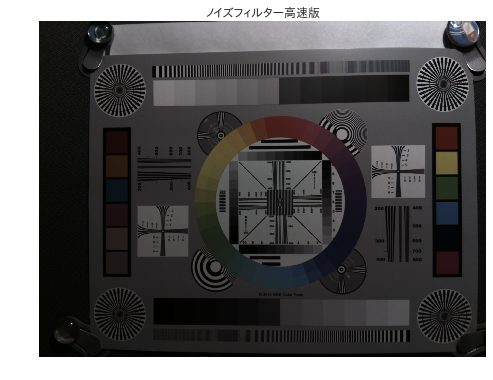

In [0]:
outimg = img_flt2.copy()
outimg = outimg.reshape((h, w, 3))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"ノイズフィルター高速版")
plt.show()

うまくいったようです。続けてカラーマトリクス補正とガンマ補正をかけてみましょう。

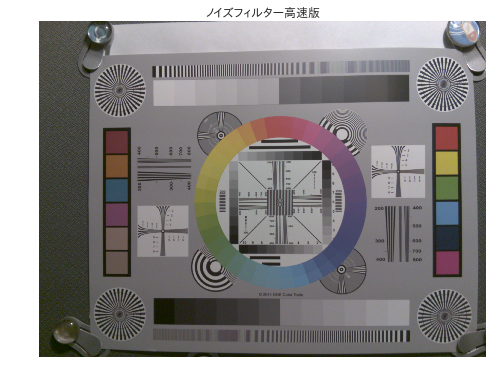

In [0]:
# カラーマトリクス処理。
ccm_flt2_img = color_correction_matrix(img_flt2, color_matrix)
# ガンマ補正処理。
gmm_flt2_img = gamma_correction(ccm_flt2_img / white_level, 2.2)

# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_flt2_img)
plt.axis('off')
plt.title(u"ノイズフィルター高速版")
plt.show()

先ほどと同じ部分を拡大して処理ができているか見てみましょう。

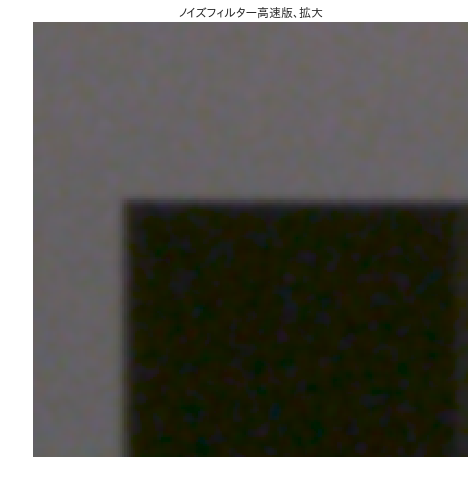

In [0]:
plt.figure(figsize=(16, 8))
plt.imshow(gmm_flt2_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター高速版、拡大")
plt.show()

うまくいっているようです。

これでノイズ処理からループが一掃されました。
処理の速度も数倍になり、実用的になりました。

### モジュール化

ノイズフィルターもモジュール化しておきます。

In [0]:
def noise_filter(rgb_img, noise_model, coef=0.1):
    """
    バイラテラルノイズフィルター処理を行う。

    Parameters
    ----------
    rgb_img: numpy array
        入力RGB画像
    noise_model: array of 2 
        ノイズモデル。
        noise[0]:傾き
        noise[1]:切片
    coef: float
        ノイズフィルター強度。
        チューニングパラメーター。

    Returns
    -------
    flt_img: numpy array
        ノイズ除去後のRGB画像
    """
    h, w, _ = rgb_img.shape
    # 平均画像からノイズ量を見積もる。
    luma_img = rgb_img.mean(2)
    average = scipy.ndimage.filters.uniform_filter(luma_img, 5, 
                                                   mode='mirror')
    sigma_map = average * noise_model[0] + noise_model[1]
    sigma_map[sigma_map < 0.1] = 0.1
    sy, sx = sigma_map.strides
    sigma_tile = as_strided(sigma_map, strides=(sy, sx, 0, 0), 
                            shape=(h, w, 5, 5))
    sigma_tile = sigma_tile[2:h-2, 2:w-2, : , :]
    # 各画素に与える重みを求める。
    sy, sx = luma_img.strides
    luma_tile = as_strided(luma_img, strides=(sy, sx, 0, 0), 
                           shape=(h, w, 5, 5))
    luma_tile = luma_tile[2:h-2, 2:w-2, : , :]
    luma_box = as_strided(luma_img, strides=(sy, sx, sy, sx), 
                          shape=(h-4, w-4, 5, 5))
    diff = luma_box - luma_tile
    weight = np.exp(-coef * diff * diff / sigma_tile)
    weight_sum = weight.sum(axis=(2, 3))
    
    # 各色毎にノイズフィルターをかける。
    flt_img = rgb_img.copy()
    for color in (0, 1, 2):
        single = rgb_img[:, :, color]
        sy, sx = single.strides
        single_boxes = as_strided(single, strides=(sy, sx, sy, sx), 
                                  shape=(h-4, w-4, 5, 5))
        single_out = (weight * single_boxes).sum(axis=(2, 3)) 
        flt_img[2:h-2, 2:w-2, color] = single_out / weight_sum
    return flt_img

正常に動作するか確認します。

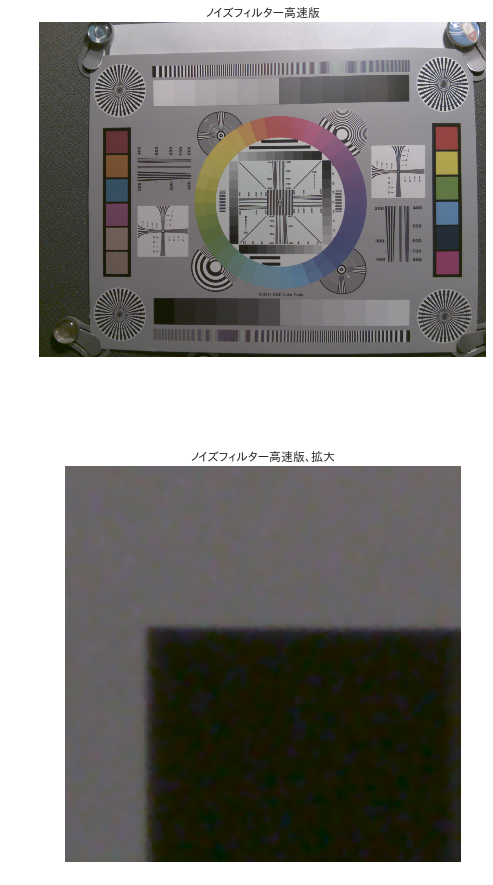

In [0]:
blc_raw = black_level_correction(raw_array, blc, pattern)
dpc_raw = defect_correction(blc_raw, threshold)
lsc_raw = lens_shading_correction(dpc_raw, lsc)
wb_raw = white_balance(lsc_raw, gains, colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
noise_model = (0.293, 10.75)
nfl3_img = noise_filter(dms_img, noise_model)
ccm_img = color_correction_matrix(nfl3_img, color_matrix)
gmm_img = gamma_correction(ccm_img / white_level, 2.2)

# 最終画像表示
plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"ノイズフィルター高速版")
plt.subplot(2, 1, 2)
plt.imshow(gmm_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター高速版、拡大")
plt.show()

動作が確認できました。

このメソッドは`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。

### まとめ

今回はノイズフィルターをとりあげ、エッジを残すノイズフィルターとしてよく使われるバイラテラル・フィルターを解説し、実装しました。

つぎは[エッジ強調](http://bit.ly/raw_chap_5_3)を扱います。